In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retailtransactiondata/Retail_Data_Response.csv
/kaggle/input/retailtransactiondata/Retail_Data_Transactions.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('/kaggle/input/retailtransactiondata/Retail_Data_Transactions.csv')

In [4]:
df.head(10)

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78
5,CS5539,26-Mar-14,81
6,CS2724,06-Feb-12,93
7,CS5902,30-Jan-15,89
8,CS6040,08-Jan-13,76
9,CS3802,20-Aug-13,75


In [5]:
df.dtypes

customer_id    object
trans_date     object
tran_amount     int64
dtype: object

In [6]:
df['trans_date'] = pd.to_datetime(df['trans_date'], format='%d-%b-%y', errors='coerce')
df.dtypes

customer_id            object
trans_date     datetime64[ns]
tran_amount             int64
dtype: object

In [7]:
df.shape


(125000, 3)

In [8]:
df.duplicated().sum()

6

In [9]:
df = df.drop_duplicates()

In [10]:
df.isnull().sum()

customer_id    0
trans_date     0
tran_amount    0
dtype: int64

In [11]:
df.describe()

,trans_date,tran_amount
count,124994,124994.000000
mean,2013-04-13 11:50:13.143030784,64.992504
min,2011-05-16 00:00:00,10.000000
25%,2012-04-29 00:00:00,47.000000
50%,2013-04-14 00:00:00,65.000000
75%,2014-03-28 00:00:00,83.000000
max,2015-03-16 00:00:00,105.000000
std,NaN,22.859952


In [12]:
df['year'] = df['trans_date'].dt.year

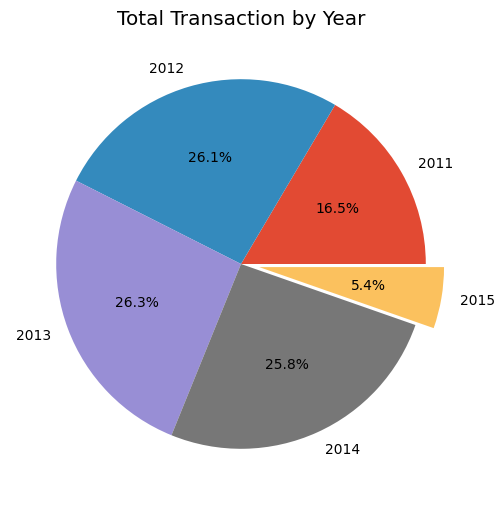

In [13]:
yearly_transactions = df.groupby('year')['tran_amount'].sum().reset_index()

# Plot the pie chart
slices = yearly_transactions['tran_amount']
labels = yearly_transactions['year']
explode = [0, 0, 0,0,0.1]

plt.figure(figsize=(6, 6))
plt.pie(slices, labels=labels, explode=explode, autopct='%1.1f%%', startangle=0)
plt.title('Total Transaction by Year')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


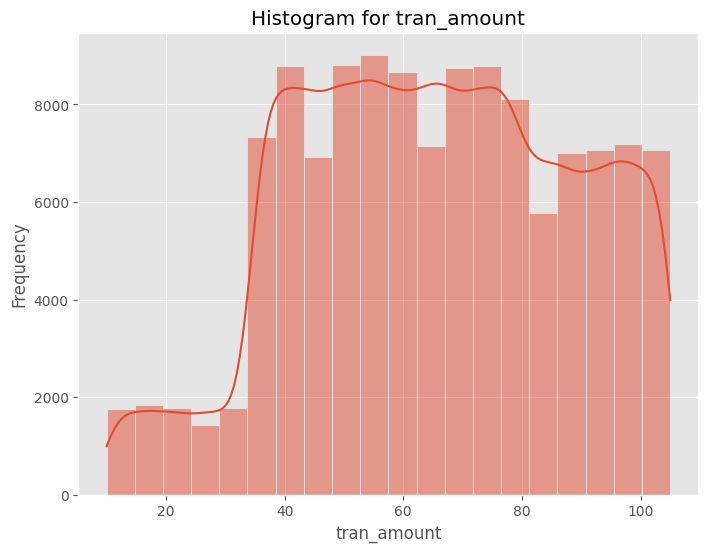

In [14]:
plt.figure(figsize=(8, 6))  
sns.histplot(data=df, x='tran_amount', bins=20, kde=True)
plt.title('Histogram for tran_amount')
plt.xlabel('tran_amount')
plt.ylabel('Frequency')
plt.show()

In [15]:
print("Skewness: %f" % df['tran_amount'].skew())
print("Kurtosis: %f" % df['tran_amount'].kurt())

Skewness: -0.125896
Kurtosis: -0.776558


# Customer Lifetime Value (CLV) Analysis

In [16]:
# Assuming the analysis date is the day after the last transaction in the dataset
analysis_date = df['trans_date'].max() + dt.timedelta(days=1)

**RFM Analysis Process**
* Recency: Calculate the number of days since the customer's last purchase.
* Frequency: Count the total number of purchases made by the customer.
* Monetary: Sum the total amount spent by the customer.


In [17]:
# Aggregate data to calculate RFM metrics
rfm = df.groupby('customer_id').agg({
    'trans_date': lambda x: (analysis_date - x.max()).days,  # Recency
    'customer_id': 'count',  # Frequency
    'tran_amount': 'sum'  # Monetary
}).rename(columns={'trans_date': 'Recency', 'customer_id': 'Frequency', 'tran_amount': 'Monetary'})

In [18]:
# Calculate the average order value
avg_order_value = rfm['Monetary'] / rfm['Frequency']

In [19]:
# Calculate the purchase frequency
purchase_frequency = rfm['Frequency'].sum() / rfm.shape[0]

In [20]:
# Calculate the repeat rate
repeat_rate = rfm[rfm['Frequency'] > 1].shape[0] / rfm.shape[0]

In [21]:
# Calculate the churn rate
churn_rate = 1 - repeat_rate

In [22]:
# Calculate the profit margin
profit_margin = 0.1  # Assume a profit margin of 10%


In [23]:
# Calculate CLV
rfm['CLV'] = (avg_order_value * purchase_frequency / churn_rate) * profit_margin

In [24]:
# Define a function to segment customers based on Recency, Frequency, and Monetary value
def segment_customer(row):
    if row['Recency'] <= 30 and row['Frequency'] >= 15 and row['Monetary'] > 1000:
        return 'P0'
    elif (30 < row['Recency'] <= 60) and (10 < row['Frequency'] <= 15) and (500 < row['Monetary'] <= 1000):
        return 'P1'
    else:
        return 'P2'

# Apply the segmentation function to the RFM DataFrame
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

In [25]:
# Print the RFM DataFrame with the Segment column
print(rfm[['Recency', 'Frequency', 'Monetary', 'CLV', 'Segment']])

             Recency  Frequency  Monetary  CLV Segment
customer_id                                           
CS1112            62         15      1012  inf      P2
CS1113            36         20      1490  inf      P2
CS1114            33         19      1432  inf      P2
CS1115            12         22      1659  inf      P0
CS1116           204         13       857  inf      P2
...              ...        ...       ...  ...     ...
CS8996            98         13       582  inf      P2
CS8997           262         14       543  inf      P2
CS8998            85         13       624  inf      P2
CS8999           258         12       383  inf      P2
CS9000            17         13       533  inf      P2

[6889 rows x 5 columns]


In [26]:
response= pd.read_csv('/kaggle/input/retailtransactiondata/Retail_Data_Response.csv')
response

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1
...,...,...
6879,CS8996,0
6880,CS8997,0
6881,CS8998,0
6882,CS8999,0


In [27]:
df_merged = df.merge(response, on='customer_id', how='left')
df_merged

,customer_id,trans_date,tran_amount,year,response
0,CS5295,2013-02-11,35,2013,1.0
1,CS4768,2015-03-15,39,2015,1.0
2,CS2122,2013-02-26,52,2013,0.0
3,CS1217,2011-11-16,99,2011,0.0
4,CS1850,2013-11-20,78,2013,0.0
...,...,...,...,...,...
124989,CS8433,2011-06-26,64,2011,0.0
124990,CS7232,2014-08-19,38,2014,0.0
124991,CS8731,2014-11-28,42,2014,0.0
124992,CS8133,2013-12-14,13,2013,0.0


In [28]:
df_merged.dtypes


customer_id            object
trans_date     datetime64[ns]
tran_amount             int64
year                    int32
response              float64
dtype: object

In [29]:
df_merged.isnull().sum()

customer_id     0
trans_date      0
tran_amount     0
year            0
response       31
dtype: int64

In [30]:
df_merged.describe()

,trans_date,tran_amount,year,response
count,124994,124994.000000,124994.000000,124963.000000
mean,2013-04-13 11:50:13.143030784,64.992504,2012.773669,0.110761
min,2011-05-16 00:00:00,10.000000,2011.000000,0.000000
25%,2012-04-29 00:00:00,47.000000,2012.000000,0.000000
50%,2013-04-14 00:00:00,65.000000,2013.000000,0.000000
75%,2014-03-28 00:00:00,83.000000,2014.000000,0.000000
max,2015-03-16 00:00:00,105.000000,2015.000000,1.000000
std,NaN,22.859952,1.158200,0.313837


In [31]:
df_merged.isnull().sum()

customer_id     0
trans_date      0
tran_amount     0
year            0
response       31
dtype: int64

In [32]:
df_merged = df_merged.dropna()

In [33]:
df_merged = df_merged.assign(response=df_merged['response'].astype('int64'))


In [34]:
set(df_merged['response'])

{0, 1}

In [35]:
df_merged.dtypes

customer_id            object
trans_date     datetime64[ns]
tran_amount             int64
year                    int32
response                int64
dtype: object

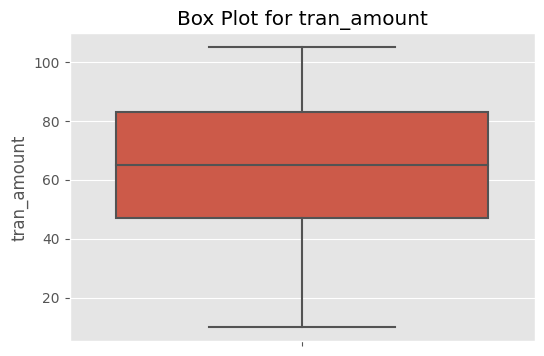

In [36]:
plt.figure(figsize=(6, 4))  
sns.boxplot(data=df_merged, y='tran_amount')
plt.title('Box Plot for tran_amount')
plt.ylabel('tran_amount')
plt.show()

In [37]:
Q1 = df_merged['tran_amount'].quantile(0.25)
Q3 = df_merged['tran_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_merged[(df_merged['tran_amount'] < lower_bound) | (df_merged['tran_amount'] > upper_bound)]
outliers.head()

,customer_id,trans_date,tran_amount,year,response


That implies there is no outlier in transaction amount.


In [38]:
df_merged = df_merged[(df_merged['tran_amount'] > lower_bound) & (df_merged['tran_amount'] < upper_bound)]
df_merged.describe()

,trans_date,tran_amount,year,response
count,124963,124963.000000,124963.000000,124963.000000
mean,2013-04-13 13:28:10.974128384,64.995735,2012.773885,0.110761
min,2011-05-16 00:00:00,10.000000,2011.000000,0.000000
25%,2012-04-29 00:00:00,47.000000,2012.000000,0.000000
50%,2013-04-15 00:00:00,65.000000,2013.000000,0.000000
75%,2014-03-28 00:00:00,83.000000,2014.000000,0.000000
max,2015-03-16 00:00:00,105.000000,2015.000000,1.000000
std,NaN,22.860005,1.158226,0.313837


In [39]:
# creating new columns

df_merged['month']= df_merged['trans_date'].dt.month
df_merged

,customer_id,trans_date,tran_amount,year,response,month
0,CS5295,2013-02-11,35,2013,1,2
1,CS4768,2015-03-15,39,2015,1,3
2,CS2122,2013-02-26,52,2013,0,2
3,CS1217,2011-11-16,99,2011,0,11
4,CS1850,2013-11-20,78,2013,0,11
...,...,...,...,...,...,...
124989,CS8433,2011-06-26,64,2011,0,6
124990,CS7232,2014-08-19,38,2014,0,8
124991,CS8731,2014-11-28,42,2014,0,11
124992,CS8133,2013-12-14,13,2013,0,12


In [40]:
# Which 3 months have had the highest transaction amounts?

monthly_Sales= df_merged.groupby('month')['tran_amount'].sum()
monthly_Sales= monthly_Sales.sort_values(ascending=False).reset_index().head(3)
monthly_Sales

,month,tran_amount
0,8,726775
1,10,725010
2,1,724089


In [41]:
# Customers having highest num of orders

customer_counts= df_merged['customer_id'].value_counts().reset_index()
customer_counts.columns=['customer_id','count']

# sort

top_5_cus= customer_counts.sort_values(by='count', ascending=False).head(5)
top_5_cus

,customer_id,count
0,CS4424,39
1,CS4320,38
2,CS3799,36
3,CS3013,35
4,CS1215,35


<Axes: xlabel='customer_id', ylabel='count'>

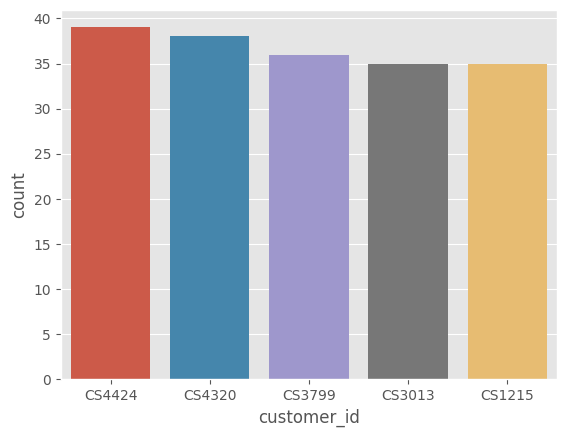

In [42]:
sns.barplot(x='customer_id',y='count',data=top_5_cus)

In [43]:
# Customers having highest value of orders

customer_sales= df_merged.groupby('customer_id')['tran_amount'].sum().reset_index()
customer_sales

# sort

top_5_sal= customer_sales.sort_values(by='tran_amount', ascending=False).head(5)
top_5_sal

,customer_id,tran_amount
3312,CS4424,2933
3208,CS4320,2647
4640,CS5752,2612
3548,CS4660,2527
2687,CS3799,2513


<Axes: xlabel='customer_id', ylabel='tran_amount'>

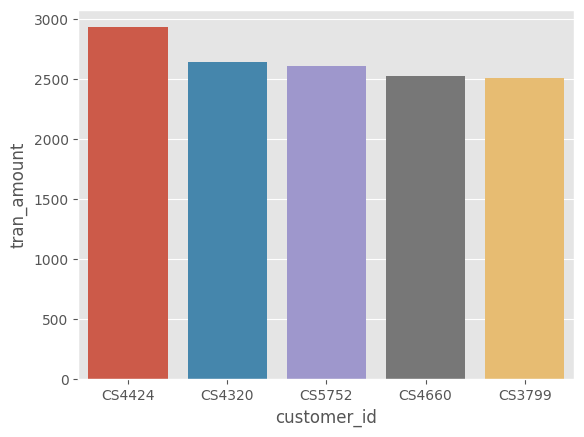

In [44]:
sns.barplot(x='customer_id',y='tran_amount',data=top_5_sal)

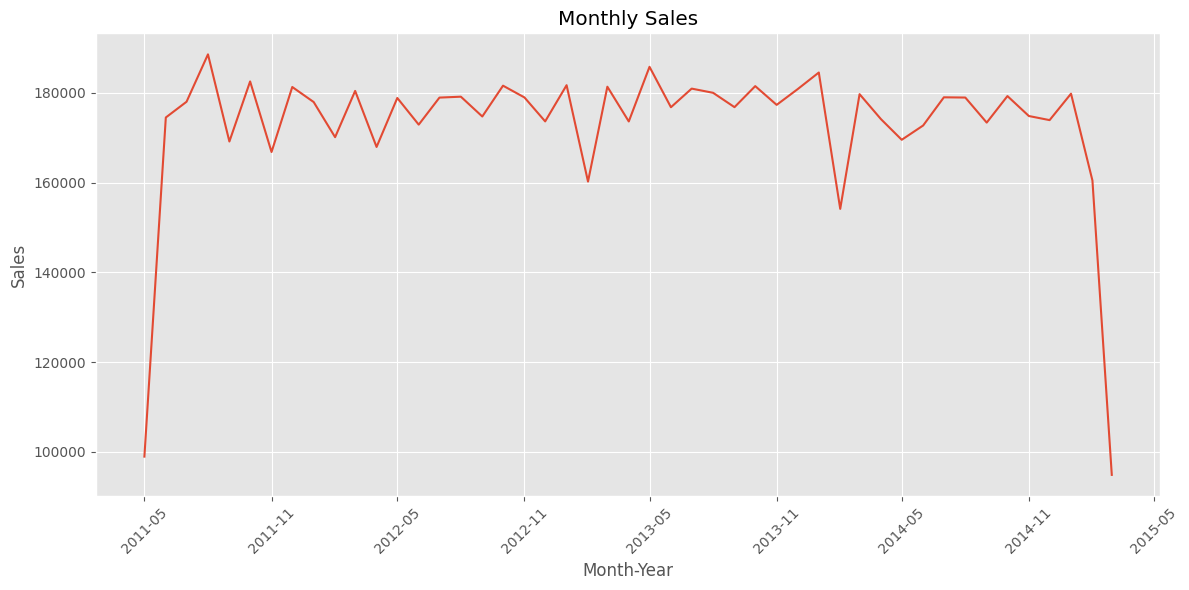

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_merged['month_year'] = df_merged['trans_date'].dt.to_period('M')
monthly_sales = df_merged.groupby('month_year')['tran_amount'].sum()

# Convert the PeriodIndex to DateTimeIndex
monthly_sales.index = monthly_sales.index.to_timestamp()

plt.figure(figsize=(12,6))  # Increase the size of the figure
plt.plot(monthly_sales.index, monthly_sales.values)  # Plot the data
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the x-axis labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Set the x-axis interval
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.title('Monthly Sales')
plt.xticks(rotation=45)  # Rotate the x-axis labels
plt.tight_layout()  # Adjust the layout for better visibility
plt.show()

<Axes: xlabel='response'>

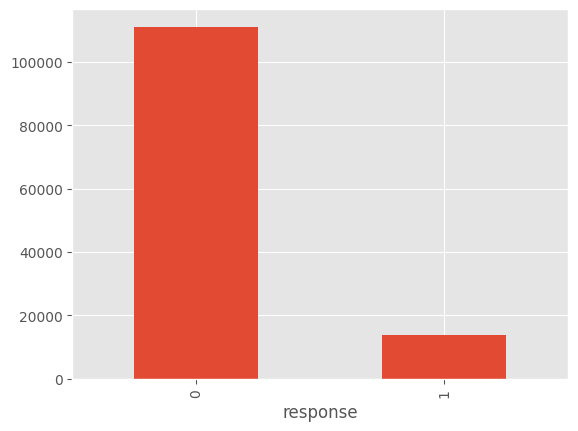

In [46]:
# Count the number of churned and active customers
churn_counts = df_merged['response'].value_counts()

# Plot
churn_counts.plot(kind='bar')

<Axes: xlabel='month_year'>

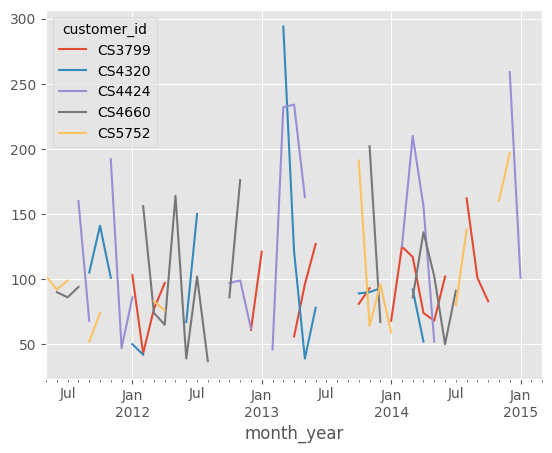

In [47]:
# Top 5 customers
top_5_customers = rfm['Monetary'].sort_values(ascending=False).head(5).index

# Filter transactions of top 5 customers
top_customers_df = df_merged[df_merged['customer_id'].isin(top_5_customers)]

# Plot their monthly sales
top_customers_sales = top_customers_df.groupby(['customer_id', 'month_year'])['tran_amount'].sum().unstack(level=0)
top_customers_sales.plot(kind='line')